In [ ]:
import tensorflow as tf
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from keras.optimizers import Adam

from IPython import display

In [ ]:
train_images = []
train_labels = []

for file in os.listdir('data'):
    img = cv2.imread('data/' + file)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (28, 28))
    train_images.append(img)

for i in range(20):
    for j in range(26):
        train_labels.append(i)

In [ ]:
train_images = np.array(train_images).astype('float32')
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5
train_labels = np.array(train_labels)

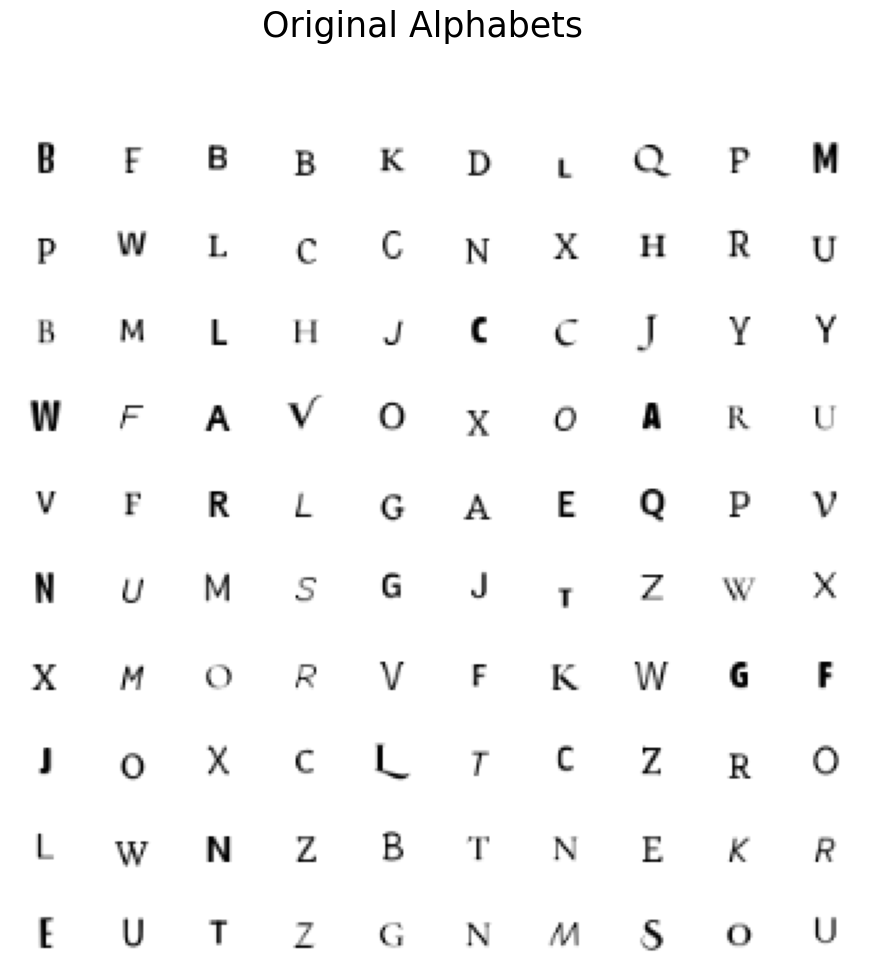

In [ ]:
def show_data(X, title=""):
    plt.figure(figsize=(11,11))

    i = 1
    for img in X:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((28, 28)), cmap='gray')
        plt.axis('off')
        i+=1
        if i>100: break

    plt.suptitle(title, fontsize = 25)
    plt.show()

show_data(train_images, title="Original Alphabets")

In [ ]:
gen_optimizer = Adam(0.00001, 0.5)
disc_optimizer = Adam(0.00001, 0.5)
noise_dim = 100

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Activation, UpSampling2D
from keras.initializers import RandomNormal

def buildGenerator():
    model = Sequential()

    model.add(Dense(1024, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Dense(7*7*128, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Reshape((7, 7, 128)))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (2, 2), padding='same',
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (3, 3), padding='same', activation = "tanh",
                     kernel_initializer=RandomNormal(0, 0.02)))

    return model
generator = buildGenerator()
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              103424    
                                                                 
 batch_normalization_9 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 6272)              6428800   
                                                                 
 batch_normalization_10 (Ba  (None, 6272)              25088     
 tchNormalization)                                               
                                                                 
 activation_7 (Activation)   (None, 6272)             

In [ ]:
def buildDiscriminator():
    model = Sequential()

    model.add(Conv2D(64, (5, 5), strides=2, padding='same',
                     kernel_initializer=RandomNormal(0, 0.02),
                     input_shape=(28,28,1)))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, (5, 5), strides=2,
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(LeakyReLU(0.2))

    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
    return model
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 5, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 5, 5, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 3200)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               409728    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 128)              

In [ ]:
from keras.models import Model
from keras.layers import Input

noise = Input(shape=(noise_dim,))
fake_data = generator(noise)
discriminator.trainable = False
output = discriminator(fake_data)
gan = Model(noise, output)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [ ]:
fixed_noise = np.random.normal(0, 1, size=(100, noise_dim))

In [ ]:
def show_generated_alphabets(title, epoch):
    imgs = generator.predict(fixed_noise)
    plt.figure(figsize=(11,11))

    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((28,28)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 25)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

In [ ]:
epochs = 5000
batch_size = 128
steps_per_epoch = len(train_images)//batch_size

for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_data = generator.predict(input_gen)

        real_data = train_images[np.random.randint(0, train_images.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, 28, 28, 1))

        input_disc = np.concatenate((real_data, fake_data))

        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9
        label_disc[batch_size:] = 0.1
        loss_disc = discriminator.train_on_batch(input_disc, label_disc)

        label_gen = np.ones(batch_size)
        loss_gen = gan.train_on_batch(input_gen, label_gen)

    print("epoch: ", epoch)
    print("discriminator loss: ", loss_disc)
    print("generator loss: ", loss_gen)
    print("-"*80)

    if epoch % 5 == 0:
        show_generated_alphabets("Generated Alphabets", epoch)